In [1]:
import json
import os
import cv2
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
import itertools
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation, BatchNormalization

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import math
import pickle

from numpy.random import seed
from tensorflow import random

In [2]:
DATA_DIR2 = './data4/'
ids = os.listdir(DATA_DIR2)
pvm_angels = []
json_fps = [os.path.join(DATA_DIR2, image_id) for image_id in ids if image_id.startswith('catalog') and image_id.endswith('catalog')]
for file in json_fps:
    with open(file, 'r') as f:
        for line in f:            
            if (line.startswith('{')):
                jsonObj = json.loads(line)   
                imgFile = jsonObj['cam/image_array']
                image = cv2.imread(os.path.join(DATA_DIR2, 'images', imgFile))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
                #image = image[65:200, :]
                #image = cv2.resize(image, (60,35))
                image = cv2.resize(image, None, fx=0.25, fy= 0.25)
                #image = cv2.resize(image, (60,60))
                jsonObj['image'] = image
                pvm_angels.append(jsonObj)


In [6]:
import albumentations as A

transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.5, brightness_by_max=False, p=1),    
     A.OneOf(
        [
            #A.IAASharpen(p=1),
            A.Sharpen(p=1),
            A.Blur(blur_limit=3, p=1),
            A.MotionBlur(blur_limit=3, p=1),
        ],
        p=0.9,
    ),
])

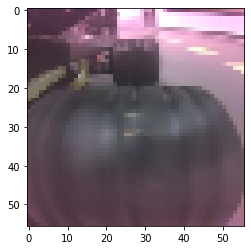

(56, 56, 3)

In [3]:
plt.imshow(pvm_angels[0]['image'])
plt.show()
pvm_angels[0]['image'].shape

In [7]:
#prepare and split data



df = pd.DataFrame(pvm_angels)

images = list(df['image'])
images = np.array(images) / 255.0
pwms = np.array(df['user/angle'])

#images = images[4:] 
#pwms = pwms[:-4]

angs = list(zip(images, pwms))
rnd.shuffle(angs)
images, pwms = zip(*angs)
images = np.array(images) 
pwms = np.array(pwms)

trainImagesX, testImagesX, trainPwmsX, testPwmsX = train_test_split(images, pwms, test_size=0.1, random_state=42)
trainImagesX, valImagesX, trainPwmsX, valPwmsX = train_test_split(trainImagesX, trainPwmsX, test_size=0.135, random_state=42)


In [8]:
#implment augmentation 
augmentedTrainImages = []
for i in range(len(trainImagesX)):
    orig_image = trainImagesX[i]
    augmentedTrainImages.append(orig_image)
    for j in range(9):
        augmentedTrainImages.append(transform(image=orig_image)['image'])

augmentedTrainImages = np.array(augmentedTrainImages)        
augmentedPwms = np.array(trainPwmsX).repeat(10)

augmentedTrainImages.shape, augmentedPwms.shape

((40100, 56, 56, 3), (40100,))

In [9]:
#SAVE DATA

data = (augmentedTrainImages, augmentedPwms, valImagesX, valPwmsX, testImagesX, testPwmsX)
with open('car_aug_data_25_vgg.pickle', 'wb') as f:
    pickle.dump(data, f )

# Usage

In [10]:
def calc_ackerman(pwms):
    L = 178 #wheelbase
    b = 165 #

    theta = pwms
    R = L/(np.tan(np.radians(theta))+0.0000001)
    tg_alpha = L/(R+np.sign(theta)*b*25)
    alpha = np.degrees(np.arctan(tg_alpha))

    return alpha

def conv_sigmoid(pwms):
    return (pwms+1)/2.0

In [ ]:
#LOAD DATA
with open('car_aug_data_25_vgg.pickle', 'rb') as f:
    data = pickle.load(f)
(augmentedTrainImages, augmentedPwms, valImagesX, valPwmsX, testImagesX, testPwmsX) = data


augmentedPwms = calc_ackerman(augmentedPwms)
valPwmsX = calc_ackerman(valPwmsX)
testPwmsX = calc_ackerman(testPwmsX)




In [11]:
augmentedPwms = conv_sigmoid(augmentedPwms)
valPwmsX = conv_sigmoid(valPwmsX)
testPwmsX = conv_sigmoid(testPwmsX)

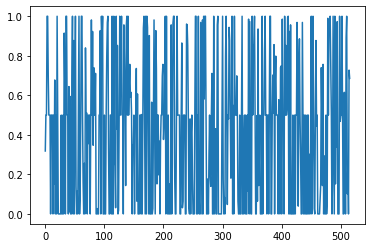

In [12]:
plt.plot(testPwmsX)

In [13]:
seed_value= 0
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

input_shape = augmentedTrainImages[0].shape

model = tf.keras.applications.VGG16(
weights='imagenet',
input_shape=input_shape,
include_top=False
)

for layer in model.layers:
      layer.trainable = False
        
x = model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=model.input, outputs=x)

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x=augmentedTrainImages,y=augmentedPwms,  validation_data=(valImagesX, valPwmsX), epochs=50)

2022-11-30 15:23:37.826437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Epoch 1/50
1254/1254 [==============================] - 8s 5ms/step - loss: 0.0806 - val_loss: 0.0591
Epoch 2/50
1254/1254 [==============================] - 6s 5ms/step - loss: 0.0625 - val_loss: 0.0497
Epoch 3/50
1254/1254 [==============================] - 6s 5ms/step - loss: 0.0564 - val_loss: 0.0445
Epoch 4/50
1254/1254 [==============================] - 6s 5ms/step - loss: 0.0534 - val_loss: 0.0455
Epoch 5/50
1254/1254 [==============================] - 6s 5ms/step - loss: 0.0505 - val_loss: 0.0420
Epoch 6/50
1254/1254 [==============================] - 6s 5ms/step - loss: 0.0479 - val_loss: 0.0394
Epoch 7/50
1254/1254 [==============================] - 6s 5ms/step - loss: 0.0459 - val_loss: 0.0375
Epoch 8/50
1254/1254 [==============================] - 6s 5ms/step - loss: 0.0439 - val_loss: 0.0377
Epoch 9/50
1254/1254 [==============================] - 6s 5ms/step - loss: 0.0423 - val_loss: 0.0402
Epoch 10/50
1254/1254 [==============================] - 6s 5ms/step - loss: 0.041

In [ ]:
#SAVE DATA

data = (augmentedTrainImages, augmentedPwms, valImagesX, valPwmsX, testImagesX, testPwmsX)
with open('car_aug_data_25_vgg.pickle', 'wb') as f:
    pickle.dump(data, f )

In [20]:
score = model.evaluate(testImagesX, testPwmsX, verbose=0)
print('Test loss:', score)


Test loss: 0.03104095719754696


In [19]:
import datetime
datetime.datetime.now()

datetime.datetime(2022, 11, 30, 15, 32, 5, 43407)

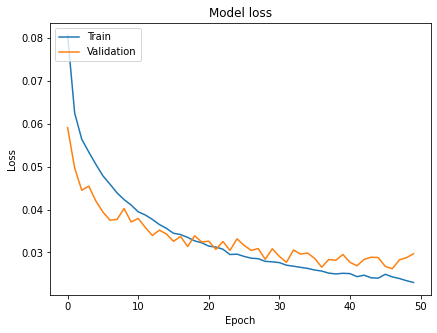

In [21]:
plt.rcParams["figure.figsize"] = (15,5)

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [43]:
def show_pwm_prediction3(pwms, preditions, text, start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))    
    
    angs = list(zip(pwms.copy(), preditions))
    angs.sort()
    pwms, preditions  = zip(*angs)
    
    data = zip()
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

          
    ax.plot(idxs, preditions, 'o', color="blue")
    ax.plot(idxs, pwms, 'o', color="green")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle by donkeycar', color="green")
        
    fig.set_figwidth(15)
    plt.show()
    
    print(pwms[5000], pwms[10000], pwms[15000],pwms[20000], pwms[25000], pwms[30000])
    print(preditions[5000], preditions[10000], preditions[15000],preditions[20000], preditions[25000], preditions[30000])
    
    

17/17 [==============================] - 0s 4ms/step


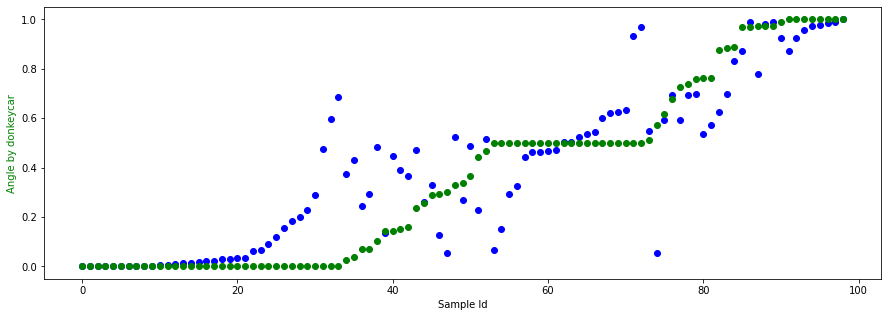

IndexError: tuple index out of range

In [44]:
predictions=model.predict(testImagesX)
pwms2 = np.array(testPwmsX[-100:-1])
predictions2 = np.array(predictions[-100:-1])
show_pwm_prediction3(pwms2,predictions2,   '', 0)
show_statistics(testPwmsX, predictions, None)

In [45]:
predictions=model.predict(augmentedTrainImages)

1254/1254 [==============================] - 5s 4ms/step


In [46]:
len(augmentedTrainImages)

40100

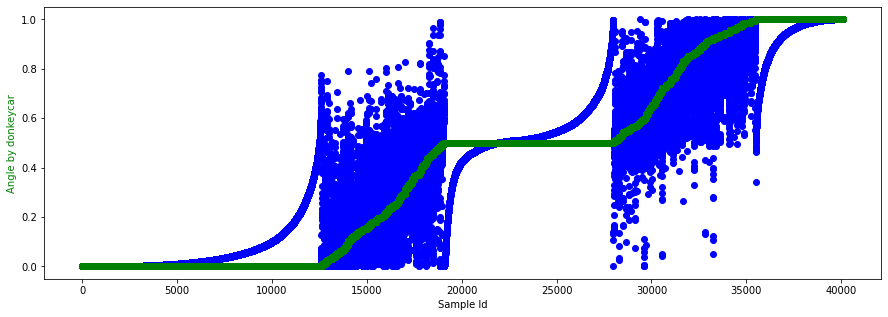

0.0 0.0 0.16015793147839996 0.5 0.5 0.6442505560423198
[0.01106042] [0.09987244] [0.05914728] [0.42192647] [0.5456939] [0.74876386]
Sample count:  40100
SSE 5163015.588337163


In [47]:


pwms2 = np.array(augmentedPwms[0:])
predictions2 = np.array(predictions[0:])
show_pwm_prediction3(pwms2,predictions2,   '', 0)
show_statistics(testPwmsX, predictions, None)


17/17 [==============================] - 0s 4ms/step


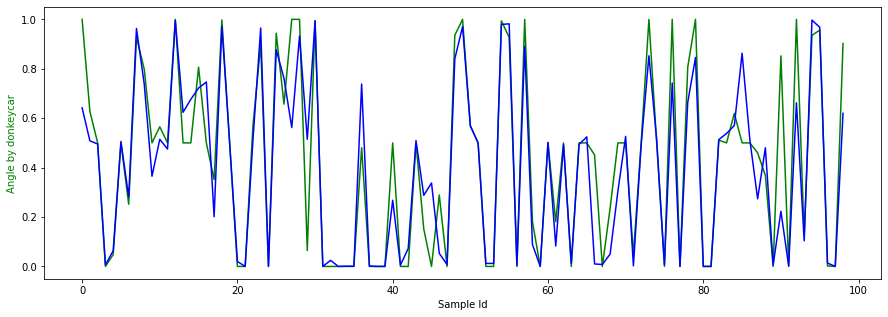

Sample count:  515
SSE 68374.54596824136


In [16]:
predictions=model.predict(testImagesX)
pwms2 = np.array(testPwmsX[-100:-1])
predictions2 = np.array(predictions[-100:-1])
show_pwm_prediction2(pwms2,predictions2,   '', 0)
show_statistics(testPwmsX, predictions, None)

In [1]:
predictions2 = np.array(testImagesX)[:]
mean = (max(predictions2) - min(predictions2))/2
predictions3 = (predictions2 -  (min(predictions2) + mean) ) / mean
#sse = np.sum(((predictions3 - pwms)**2))
sse = np.sum(((predictions - testPwmsX)**2))

print('Sample count: ', len(predictions3))
print('SSE', sse)

NameError: name 'np' is not defined

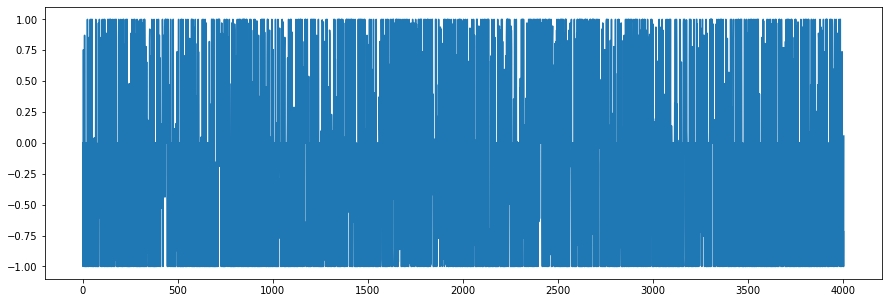

In [45]:

plt.plot(trainPwmsX)

17/17 [==============================] - 0s 1ms/step


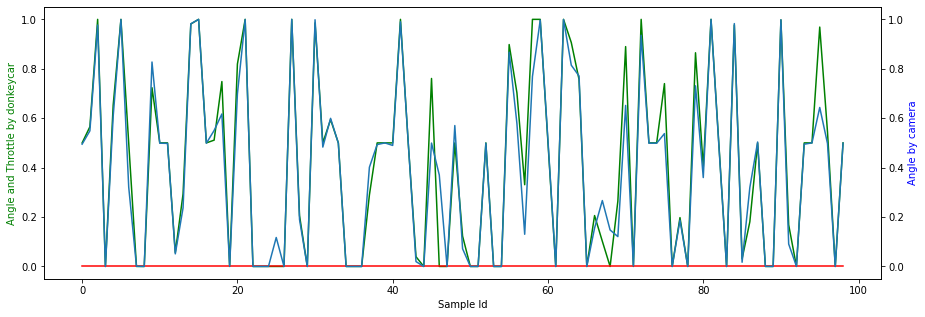

Sample count:  515
SSE 73768.76681665599


In [32]:
predictions=model.predict(testImagesX)
pwms2 = np.array(testPwmsX[-100:-1])
predictions2 = np.array(predictions[-100:-1])
show_pwm_prediction(pwms2,predictions2, np.zeros(len(predictions2)),  '', 0)
show_statistics(testPwmsX, predictions, None)

17/17 [==============================] - 0s 1ms/step


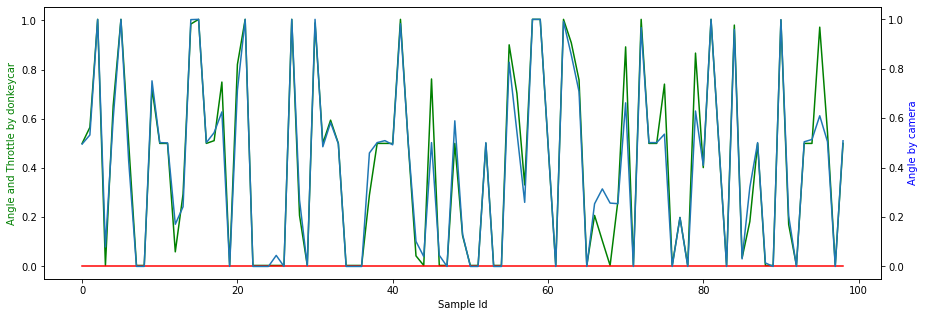

Sample count:  515
SSE 73494.46975705601


In [102]:
predictions=model.predict(testImagesX)
pwms2 = np.array(testPwmsX[-100:-1])
predictions2 = np.array(predictions[-100:-1])
show_pwm_prediction(pwms2,predictions2, np.zeros(len(predictions2)),  '', 0)
show_statistics(testPwmsX, predictions, None)

17/17 [==============================] - 0s 1ms/step


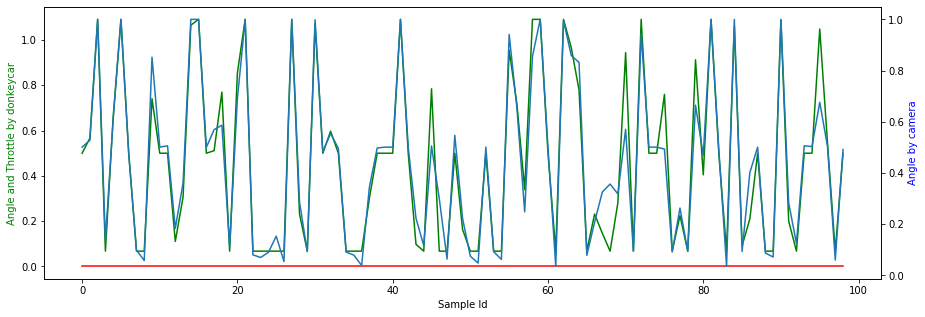

Sample count:  515
SSE 68737.58848588043


In [84]:
predictions=model.predict(testImagesX)
pwms2 = np.array(testPwmsX[-100:-1])
predictions2 = np.array(predictions[-100:-1])
show_pwm_prediction(pwms2,predictions2, np.zeros(len(predictions2)),  '', 0)
show_statistics(testPwmsX, predictions, None)

17/17 [==============================] - 0s 975us/step


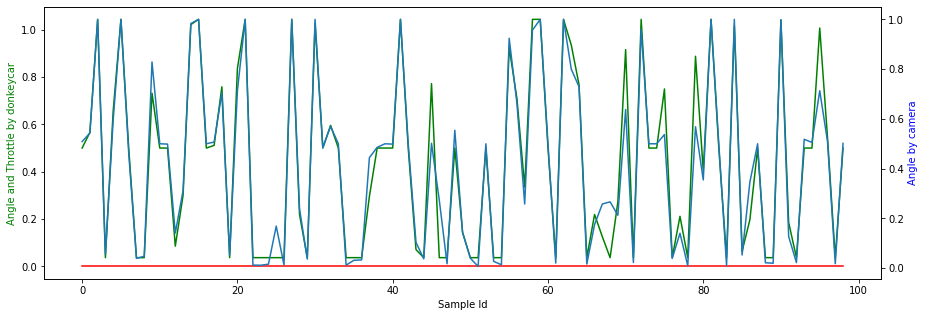

Sample count:  515
SSE 71753.24106676024


In [89]:
predictions=model.predict(testImagesX)
pwms2 = np.array(testPwmsX[-100:-1])
predictions2 = np.array(predictions[-100:-1])
show_pwm_prediction(pwms2,predictions2, np.zeros(len(predictions2)),  '', 0)
show_statistics(testPwmsX, predictions, None)

17/17 [==============================] - 0s 1ms/step


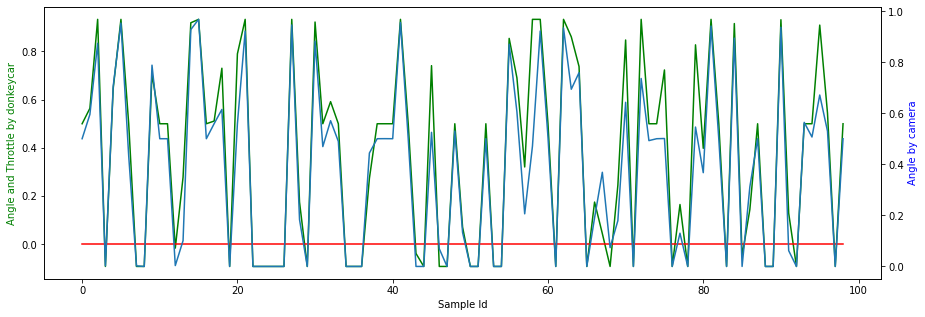

Sample count:  515
SSE 74549.75468456144


In [77]:
predictions=model.predict(testImagesX)
pwms2 = np.array(testPwmsX[-100:-1])
predictions2 = np.array(predictions[-100:-1])
show_pwm_prediction(pwms2,predictions2, np.zeros(len(predictions2)),  '', 0)
show_statistics(testPwmsX, predictions, None)

In [ ]:
predict_x=model.predict(testImagesX) 
classex_x = np.argmax(predict_x,axis=1)

In [11]:
model.save("x_model_s_dave_full") 

INFO:tensorflow:Assets written to: x_model_s_dave_full/assets


INFO:tensorflow:Assets written to: x_model_s_dave_full/assets


In [3]:
from tensorflow.keras.models import Sequential, save_model, load_model
model = load_model("x_model_s", compile = True)

import pickle
with open("x_model_s.pickle", "wb") as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://bd61f946-4944-4b59-b0f6-c41bf13e6df2/assets


INFO:tensorflow:Assets written to: ram://bd61f946-4944-4b59-b0f6-c41bf13e6df2/assets


In [20]:
augmentedTrainImages.shape

(23660, 34, 56, 3)

In [21]:
valImagesX.shape

(370, 34, 56, 3)

In [22]:
testImagesX.shape

(304, 34, 56, 3)

In [23]:
history

In [25]:
def show_pwm_prediction(pwms, preditions, throttle, text,   start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))
    
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

    ax.plot(idxs, pwms, color="green")
        
    ax.plot(idxs, throttle, color="red")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle and Throttle by donkeycar', color="green")
    
    ax2 = ax.twinx()
    ax2.plot(idxs, preditions)
    ax2.set_ylabel('Angle by camera', color="blue")
    
    fig.set_figwidth(15)
    plt.show()

def show_pwm_prediction2(pwms, preditions, text,   start_id):
    
    
    idxs = range(start_id, start_id+len(preditions))
    
    fig,ax = plt.subplots()
    ax.set_title(text)
    fig.figsize=(82, 6)

    ax.plot(idxs, pwms, color="green")
        
    ax.plot(idxs, preditions, color="blue")
    
    ax.set_xlabel('Sample Id')
    ax.set_ylabel('Angle by donkeycar', color="green")
        
    fig.set_figwidth(15)
    plt.show()
    
def show_statistics(pwms, predictions, frames=None):

    #print('Sample count: ', len(predictions))
    #print('Cov', np.corrcoef([pwms,predictions]))    

    if frames == None:
        frames = len(predictions)
    predictions2 = predictions[:frames]
    mean = (max(predictions2) - min(predictions2))/2
    predictions3 = (predictions2 -  (min(predictions2) + mean) ) / mean
    #sse = np.sum(((predictions3 - pwms)**2))
    sse = np.sum(((predictions - pwms)**2))
    
    print('Sample count: ', len(predictions3))
    print('SSE', sse)

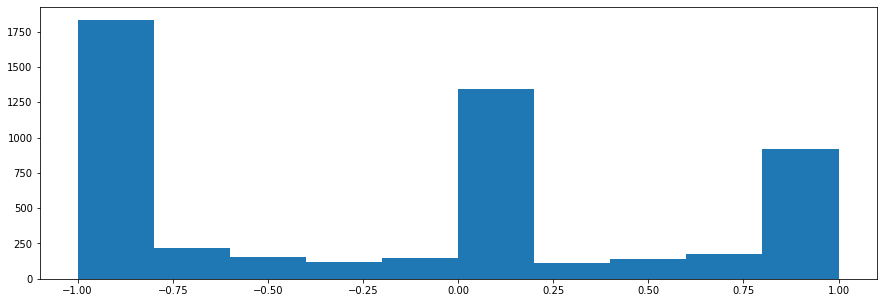

In [20]:
#prepare and split data

df = pd.DataFrame(pvm_angels)

pwms = np.array(df['user/angle'])
plt.hist(pwms, bins = 10)
plt.show()                

In [45]:

import pickle 
object = dict() 
filehandler = open('filename', 'wb') 
pickle.dump(object, filehandler)

In [8]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
#tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-11-23 17:54:22.818577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
